In [1]:
import sys
sys.path.append("../functions")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from functions import load_csv
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

DATA_DIR = Path("../data/raw")

PD_KW = dict(dtype_backend="pyarrow")

df_chess = load_csv(DATA_DIR / "chessData.csv")

 Extrayendo características de las posiciones...
Procesado: 0 posiciones
Procesado: 100,000 posiciones
Procesado: 200,000 posiciones
Procesado: 300,000 posiciones
Procesado: 400,000 posiciones
Procesado: 500,000 posiciones
Procesado: 600,000 posiciones
Procesado: 700,000 posiciones
Procesado: 800,000 posiciones
Procesado: 900,000 posiciones
Procesado: 1,000,000 posiciones
Procesado: 1,100,000 posiciones
Procesado: 1,200,000 posiciones
Procesado: 1,300,000 posiciones
Procesado: 1,400,000 posiciones
Procesado: 1,500,000 posiciones
Procesado: 1,600,000 posiciones
Procesado: 1,700,000 posiciones
Procesado: 1,800,000 posiciones
Procesado: 1,900,000 posiciones
Procesado: 2,000,000 posiciones
Procesado: 2,100,000 posiciones
Procesado: 2,200,000 posiciones
Procesado: 2,300,000 posiciones
Procesado: 2,400,000 posiciones
Procesado: 2,500,000 posiciones
Procesado: 2,600,000 posiciones
Procesado: 2,700,000 posiciones
Procesado: 2,800,000 posiciones
Procesado: 2,900,000 posiciones
Procesado: 3,000,

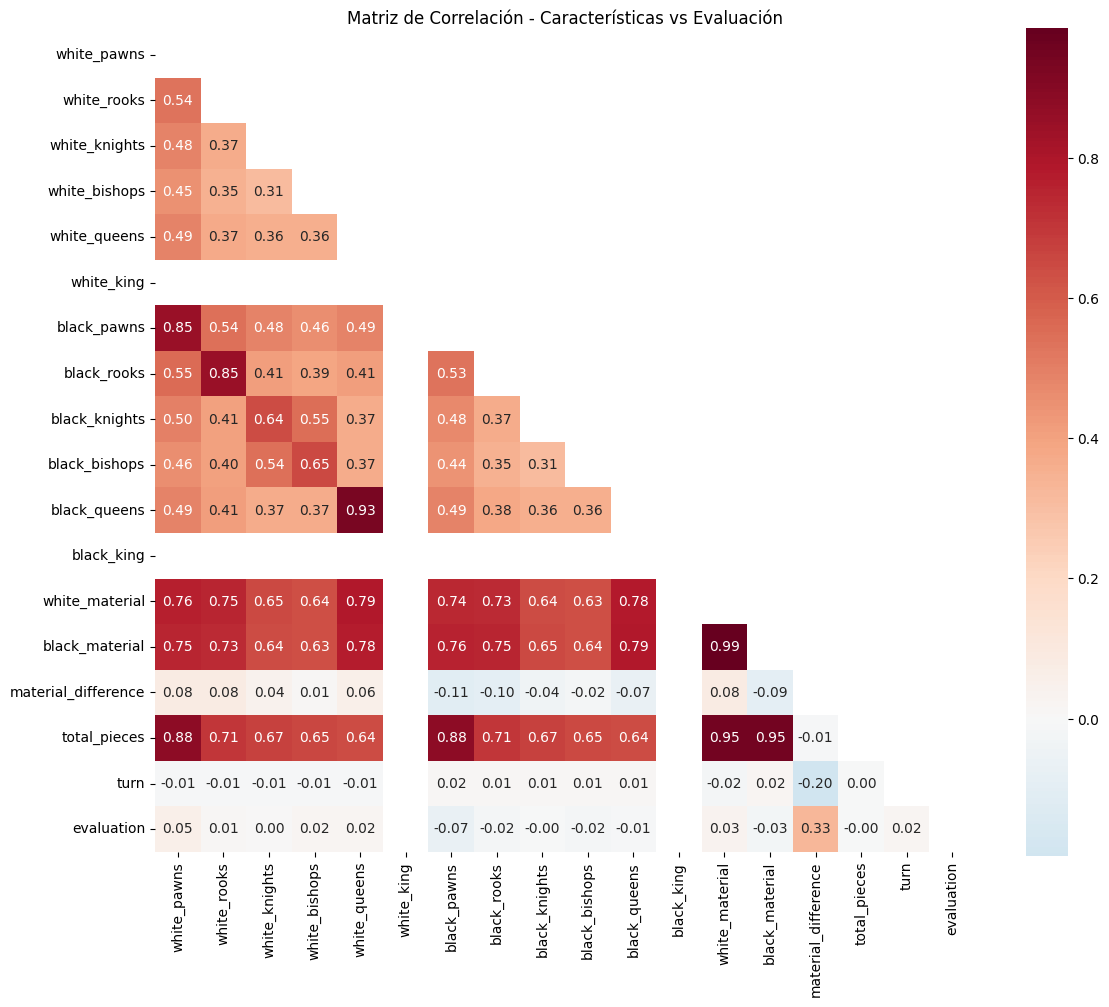


🔍 Top 10 correlaciones con la evaluación:
material_difference : 0.326
black_pawns         : 0.069
white_pawns         : 0.054
white_material      : 0.030
black_material      : 0.026
white_queens        : 0.025
white_bishops       : 0.022
turn                : 0.019
black_rooks         : 0.019
black_bishops       : 0.017

 Análisis específicos:


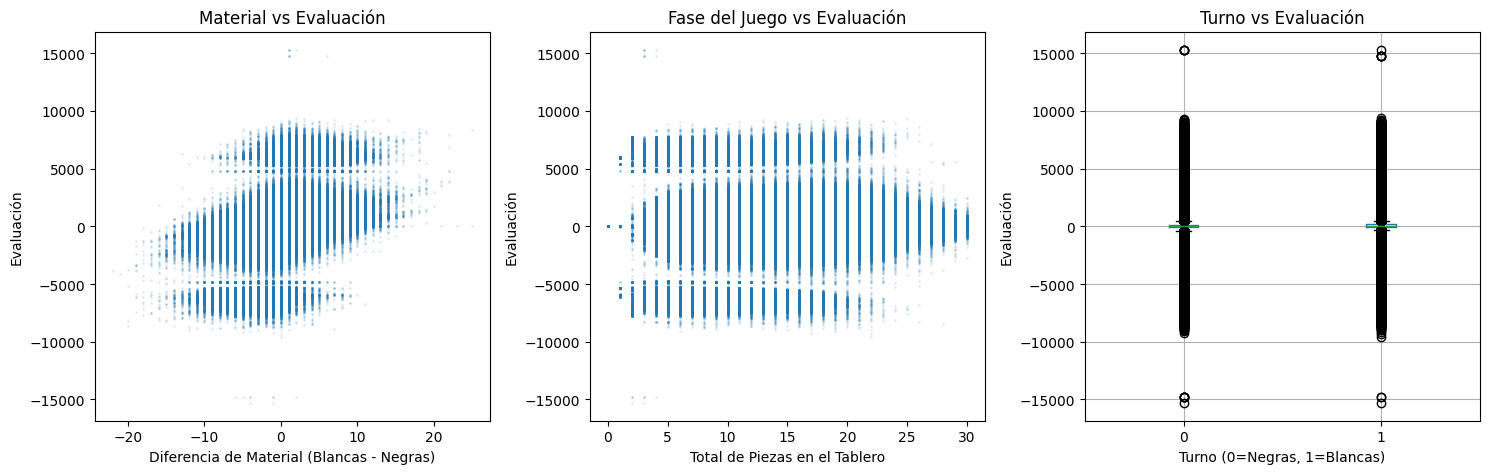

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def extract_chess_features(fen_string):
    """Extrae características numéricas de una posición FEN"""
    
    # Separar las partes del FEN
    parts = fen_string.split(' ')
    board = parts[0]
    
    # Contar material por pieza
    features = {
        'white_pawns': board.count('P'),
        'white_rooks': board.count('R'),
        'white_knights': board.count('N'),
        'white_bishops': board.count('B'),
        'white_queens': board.count('Q'),
        'white_king': board.count('K'),
        'black_pawns': board.count('p'),
        'black_rooks': board.count('r'),
        'black_knights': board.count('n'),
        'black_bishops': board.count('b'),
        'black_queens': board.count('q'),
        'black_king': board.count('k'),
    }
    
    # Calcular material total
    piece_values = {'P': 1, 'R': 5, 'N': 3, 'B': 3, 'Q': 9, 'K': 0,
                   'p': 1, 'r': 5, 'n': 3, 'b': 3, 'q': 9, 'k': 0}
    
    white_material = sum(board.count(piece) * value 
                        for piece, value in piece_values.items() 
                        if piece.isupper())
    black_material = sum(board.count(piece) * value 
                        for piece, value in piece_values.items() 
                        if piece.islower())
    
    features.update({
        'white_material': white_material,
        'black_material': black_material,
        'material_difference': white_material - black_material,
        'total_pieces': sum(features[key] for key in features if 'king' not in key),
        'castling_rights': parts[2] if len(parts) > 2 else '',
        'turn': 1 if len(parts) > 1 and parts[1] == 'w' else 0,  # 1=blancas, 0=negras
    })
    
    return features

def analyze_chess_correlations(df):
    """Analiza correlaciones en datos de ajedrez"""
    
    print(" Extrayendo características de las posiciones...")
    
    # Extraer características de cada FEN
    features_list = []
    for idx, fen in enumerate(df.iloc[:, 0]):  # Primera columna = FEN
        if idx % 100000 == 0:
            print(f"Procesado: {idx:,} posiciones")
        
        try:
            features = extract_chess_features(fen)
            features['evaluation'] = df.iloc[idx, 1]  # Segunda columna = evaluación
            features_list.append(features)
        except:
            continue
    
    # Crear DataFrame con características
    chess_df = pd.DataFrame(features_list)
    
    # Convertir evaluación a numérica
    chess_df['evaluation'] = pd.to_numeric(chess_df['evaluation'], errors='coerce')
    chess_df = chess_df.dropna(subset=['evaluation'])
    
    print(f" Dataset procesado: {len(chess_df):,} posiciones con características")
    
    # Seleccionar solo columnas numéricas para correlación
    numeric_cols = chess_df.select_dtypes(include=[np.number]).columns
    
    # Matriz de correlación
    correlation_matrix = chess_df[numeric_cols].corr()
    
    # Visualización
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                fmt='.2f',
                square=True)
    plt.title('Matriz de Correlación - Características vs Evaluación')
    plt.tight_layout()
    plt.show()
    
    # Top correlaciones con evaluación
    eval_correlations = correlation_matrix['evaluation'].abs().sort_values(ascending=False)
    print("\n🔍 Top 10 correlaciones con la evaluación:")
    for feature, corr in eval_correlations.head(11).items():  # 11 porque incluye evaluation vs evaluation
        if feature != 'evaluation':
            print(f"{feature:20s}: {corr:.3f}")
    
    # Análisis específicos
    print("\n Análisis específicos:")
    
    # 1. Material vs Evaluación
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.scatter(chess_df['material_difference'], chess_df['evaluation'], alpha=0.1, s=1)
    plt.xlabel('Diferencia de Material (Blancas - Negras)')
    plt.ylabel('Evaluación')
    plt.title('Material vs Evaluación')
    
    # 2. Total de piezas vs Evaluación (fase del juego)
    plt.subplot(1, 3, 2)
    plt.scatter(chess_df['total_pieces'], chess_df['evaluation'], alpha=0.1, s=1)
    plt.xlabel('Total de Piezas en el Tablero')
    plt.ylabel('Evaluación')
    plt.title('Fase del Juego vs Evaluación')
    
    # 3. Turno vs Evaluación
    plt.subplot(1, 3, 3)
    chess_df.boxplot(column='evaluation', by='turn', ax=plt.gca())
    plt.xlabel('Turno (0=Negras, 1=Blancas)')
    plt.ylabel('Evaluación')
    plt.title('Turno vs Evaluación')
    plt.suptitle('')
    
    plt.tight_layout()
    plt.show()
    
    return chess_df, correlation_matrix

# Usar con tu dataset
chess_features_df, corr_matrix = analyze_chess_correlations(df_chess)

🔍 Analizando decisividad por tipo de pieza...

 CORRELACIÓN PIEZA vs EVALUACIÓN (ordenado por impacto):
--------------------------------------------------
Pawn        : +0.2224
Queen       : +0.0891
Rook        : +0.0622
Bishop      : +0.0465
Knight      : +0.0058


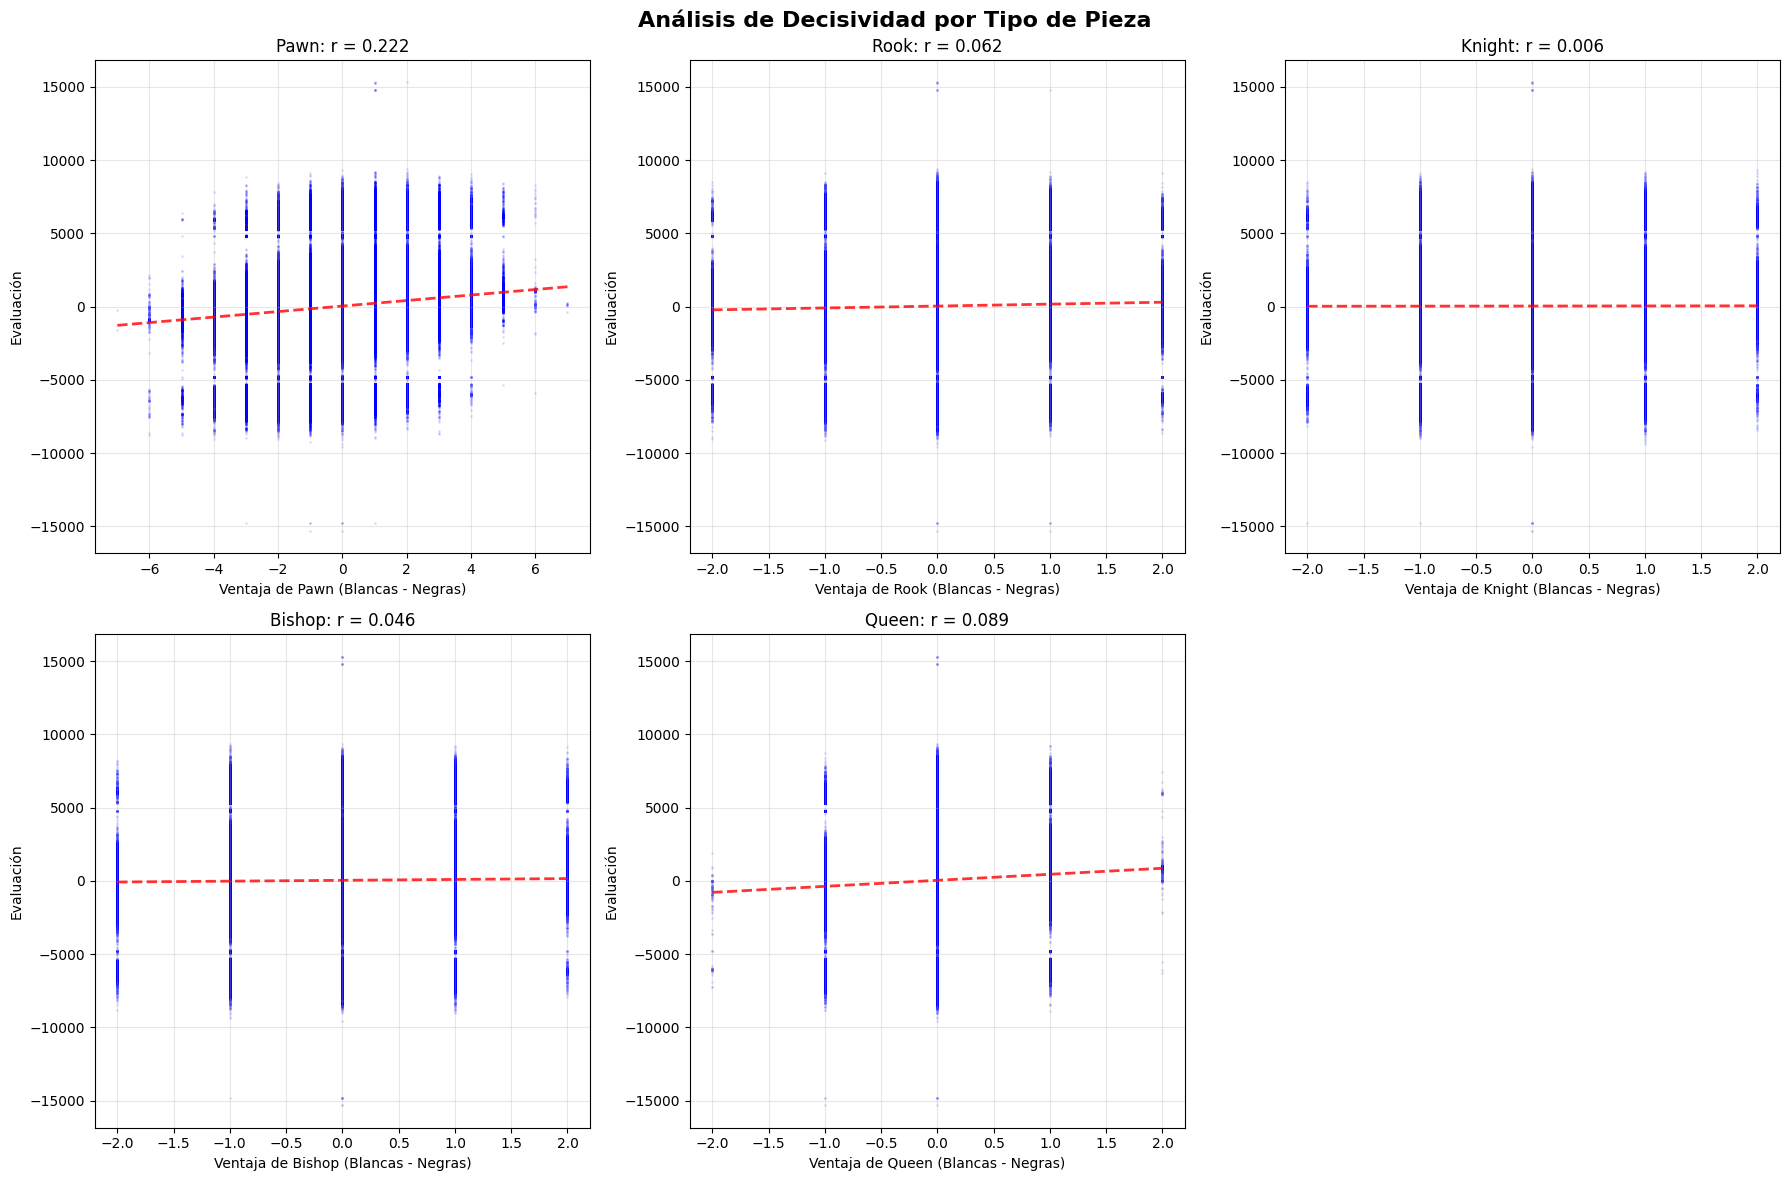


 ANÁLISIS CATEGÓRICO: Ventaja vs Desventaja vs Igualdad
------------------------------------------------------------

Pawn:
                           count     mean       std  median
pawn_advantage_category                                    
Desventaja               2795455 -193.422  1044.271   -79.0
Igualdad                 7018277   41.265   545.762    15.0
Ventaja                  2954149  281.676  1006.759   128.0

Rook:
                            count     mean       std  median
rook_advantage_category                                     
Desventaja                 762027  -84.182  1199.912   -13.0
Igualdad                 11128477   41.627   744.749    14.0
Ventaja                    877377  207.351  1145.886   119.0

Knight:
                             count    mean      std  median
knight_advantage_category                                  
Desventaja                 2465567  41.896  756.907    31.0
Igualdad                   8120924  43.740  836.734    15.0
Ventaja       

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14904\1723911308.py:118: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ASUS\Desktop\stocksalmon\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


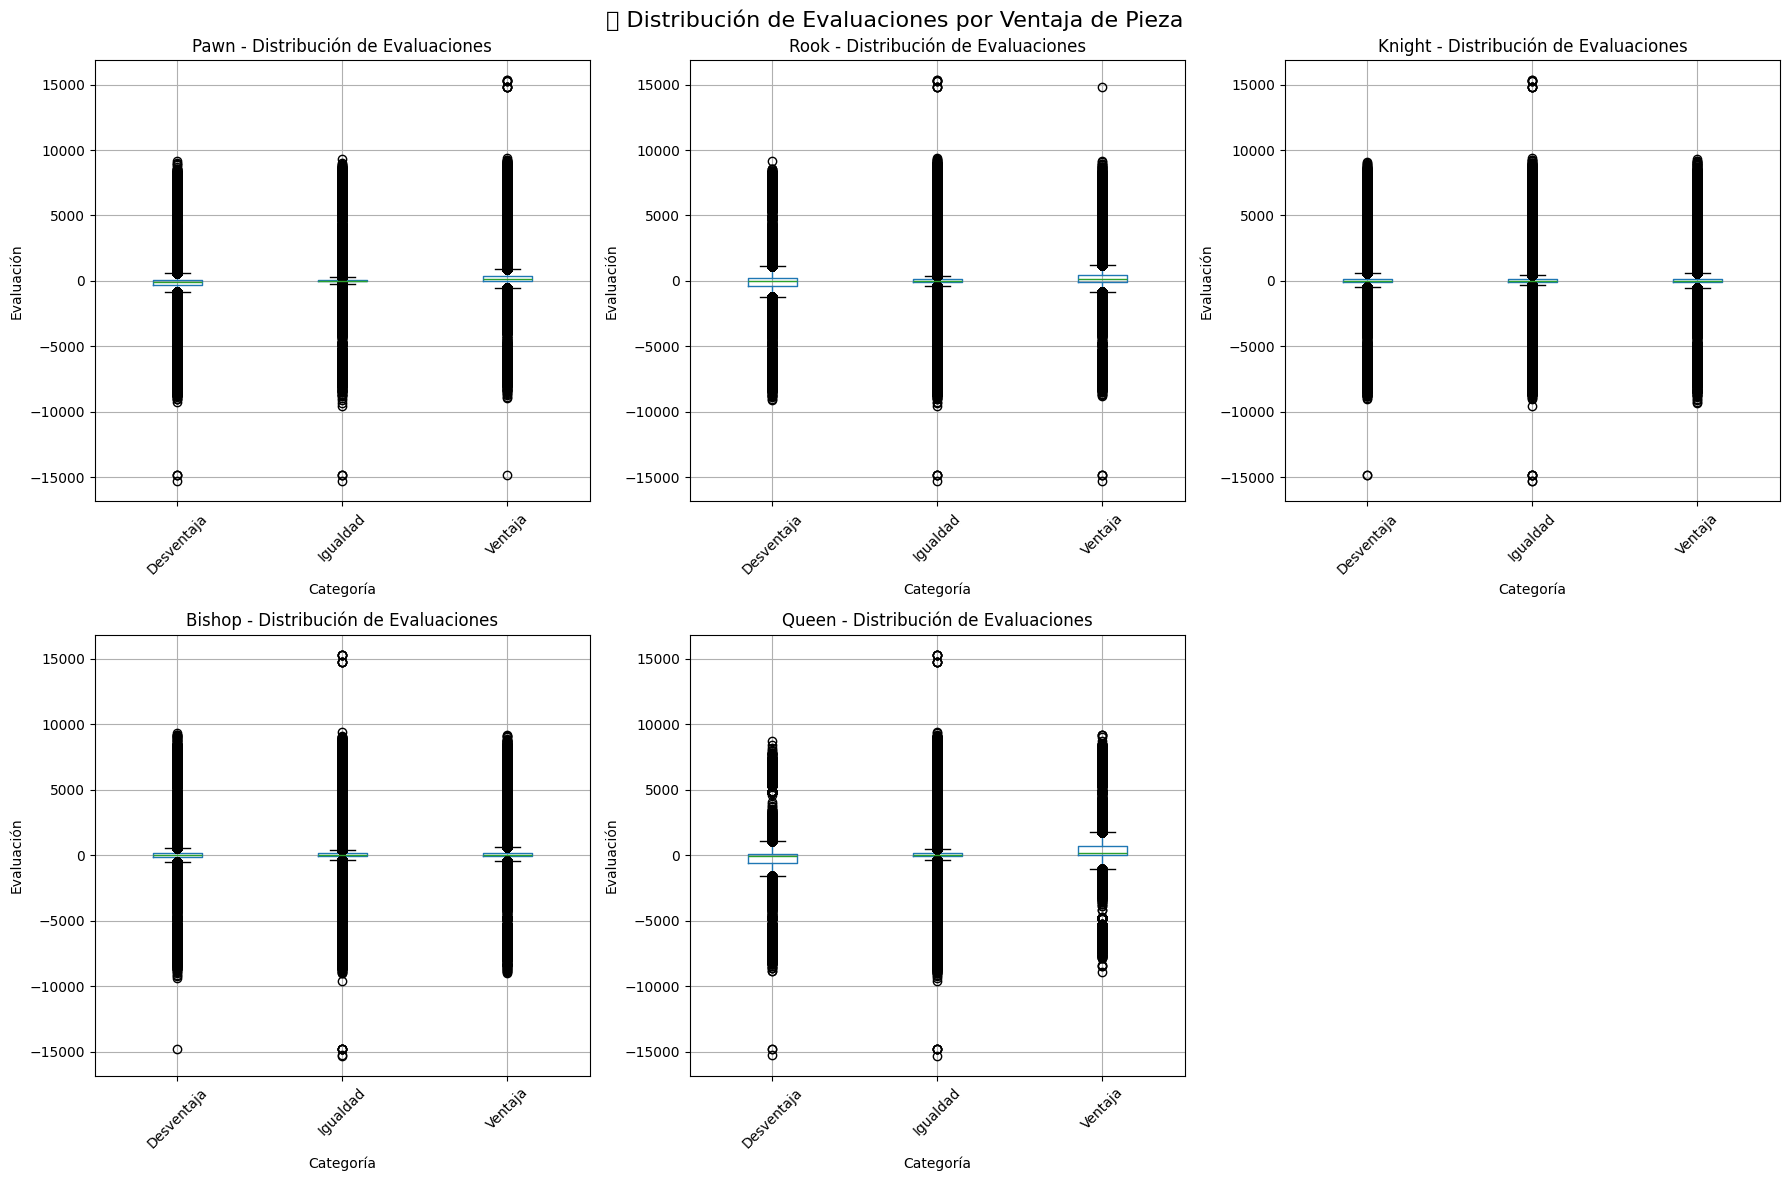


 RANKING DE DECISIVIDAD (Diferencia Ventaja vs Desventaja):
-------------------------------------------------------
Pieza        Decisividad  |Correlación|
----------------------------------------
Queen        +825.714     0.089   
Pawn         +475.098     0.222   
Rook         +291.533     0.062   
Bishop       +118.778     0.046   
Knight        +14.268     0.006   


In [3]:
def analyze_piece_decisiveness(chess_df):
    """Analiza qué piezas son más decisivas en la evaluación"""
    
    print("🔍 Analizando decisividad por tipo de pieza...")
    
    # Calcular ventajas por tipo de pieza
    piece_advantages = {
        'pawn_advantage': chess_df['white_pawns'] - chess_df['black_pawns'],
        'rook_advantage': chess_df['white_rooks'] - chess_df['black_rooks'],
        'knight_advantage': chess_df['white_knights'] - chess_df['black_knights'],
        'bishop_advantage': chess_df['white_bishops'] - chess_df['black_bishops'],
        'queen_advantage': chess_df['white_queens'] - chess_df['black_queens']
    }
    
    # Agregar al DataFrame
    for name, advantage in piece_advantages.items():
        chess_df[name] = advantage
    
    # 1. CORRELACIONES: ¿Qué pieza correlaciona más con la evaluación?
    correlations = {}
    for piece, advantage in piece_advantages.items():
        corr = chess_df['evaluation'].corr(advantage)
        correlations[piece] = corr
    
    # Ordenar por correlación absoluta
    sorted_correlations = sorted(correlations.items(), 
                                key=lambda x: abs(x[1]), 
                                reverse=True)
    
    print("\n CORRELACIÓN PIEZA vs EVALUACIÓN (ordenado por impacto):")
    print("-" * 50)
    for piece, corr in sorted_correlations:
        piece_name = piece.replace('_advantage', '').replace('_', ' ').title()
        print(f"{piece_name:12s}: {corr:+.4f}")
    
    # 2. VISUALIZACIÓN: Correlaciones por pieza
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, (piece, advantage) in enumerate(piece_advantages.items()):
        ax = axes[i]
        
        # Scatter plot
        ax.scatter(advantage, chess_df['evaluation'], alpha=0.1, s=1, color='blue')
        
        # Línea de tendencia
        z = np.polyfit(advantage, chess_df['evaluation'], 1)
        p = np.poly1d(z)
        ax.plot(advantage.sort_values(), p(advantage.sort_values()), "r--", alpha=0.8, linewidth=2)
        
        # Etiquetas
        piece_name = piece.replace('_advantage', '').replace('_', ' ').title()
        ax.set_xlabel(f'Ventaja de {piece_name} (Blancas - Negras)')
        ax.set_ylabel('Evaluación')
        ax.set_title(f'{piece_name}: r = {correlations[piece]:.3f}')
        ax.grid(True, alpha=0.3)
    
    # Ocultar el último subplot vacío
    axes[-1].axis('off')
    
    plt.suptitle('Análisis de Decisividad por Tipo de Pieza', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 3. ANÁLISIS CATEGÓRICO: Efecto de tener ventaja vs desventaja
    print("\n ANÁLISIS CATEGÓRICO: Ventaja vs Desventaja vs Igualdad")
    print("-" * 60)
    
    categorical_analysis = {}
    
    for piece, advantage in piece_advantages.items():
        # Categorizar: ventaja (+1), igualdad (0), desventaja (-1)
        categories = []
        for val in advantage:
            if val > 0:
                categories.append('Ventaja')
            elif val < 0:
                categories.append('Desventaja')
            else:
                categories.append('Igualdad')
        
        chess_df[f'{piece}_category'] = categories
        
        # Estadísticas por categoría
        stats_by_cat = chess_df.groupby(f'{piece}_category')['evaluation'].agg([
            'count', 'mean', 'std', 'median'
        ]).round(3)
        
        piece_name = piece.replace('_advantage', '').replace('_', ' ').title()
        print(f"\n{piece_name}:")
        print(stats_by_cat)
        
        categorical_analysis[piece] = stats_by_cat
    
    # 4. VISUALIZACIÓN CATEGÓRICA: Boxplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, (piece, advantage) in enumerate(piece_advantages.items()):
        ax = axes[i]
        
        piece_name = piece.replace('_advantage', '').replace('_', ' ').title()
        category_column = f'{piece}_category'
        
        # Boxplot
        chess_df.boxplot(column='evaluation', by=category_column, ax=ax)
        ax.set_title(f'{piece_name} - Distribución de Evaluaciones')
        ax.set_xlabel('Categoría')
        ax.set_ylabel('Evaluación')
        
        # Mejorar visualización
        ax.tick_params(axis='x', rotation=45)
    
    # Ocultar el último subplot vacío
    axes[-1].axis('off')
    
    plt.suptitle('📦 Distribución de Evaluaciones por Ventaja de Pieza', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # 5. RANKING DE DECISIVIDAD
    print("\n RANKING DE DECISIVIDAD (Diferencia Ventaja vs Desventaja):")
    print("-" * 55)
    
    decisiveness_ranking = []
    
    for piece, advantage in piece_advantages.items():
        category_column = f'{piece}_category'
        
        if 'Ventaja' in chess_df[category_column].values and 'Desventaja' in chess_df[category_column].values:
            ventaja_mean = chess_df[chess_df[category_column] == 'Ventaja']['evaluation'].mean()
            desventaja_mean = chess_df[chess_df[category_column] == 'Desventaja']['evaluation'].mean()
            decisiveness = ventaja_mean - desventaja_mean
            
            piece_name = piece.replace('_advantage', '').replace('_', ' ').title()
            decisiveness_ranking.append((piece_name, decisiveness, abs(correlations[piece])))
    
    # Ordenar por decisividad
    decisiveness_ranking.sort(key=lambda x: x[1], reverse=True)
    
    print(f"{'Pieza':<12} {'Decisividad':<12} {'|Correlación|':<12}")
    print("-" * 40)
    for piece, decisiveness, abs_corr in decisiveness_ranking:
        print(f"{piece:<12} {decisiveness:+8.3f}     {abs_corr:<8.3f}")
    
    return chess_df, categorical_analysis, decisiveness_ranking

# Ejecutar análisis completo
chess_features_extended, categorical_stats, decisiveness_rank = analyze_piece_decisiveness(chess_features_df)